<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><b>Общий вывод по проекту</b></a></span></li><li><span><a href="#Общий-вывод-по-проекту-V2" data-toc-modified-id="Общий-вывод-по-проекту-V2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><b>Общий вывод по проекту V2</b></a></span></li><li><span><a href="#Общий-вывод-по-проекту-V3" data-toc-modified-id="Общий-вывод-по-проекту-V3-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><b>Общий вывод по проекту V3</b></a></span></li></ul></div>

# Отток клиентов

**Описание:** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Данные:** Исторические данные о поведении клиентов и расторжении договоров с банком. 

**Цель:** Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

**План работы:**

1. Импорт данных.

2. Обзор данных.

3. Предобработка данных.
 
4. Построение модели с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. 

5. Проверка *F1*-меры на тестовой выборке.

6. Дополнительно измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

## Импорт и изучение данных:

In [1]:
#Импортируем все необходимые библиотеки:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.utils import shuffle

In [3]:
# Прочитаем файл:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
#Изучение данных:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Вывод: в таблице 1000 строк, 14 столбцов и ненулевых значений во всех столбцах 1000, кроме столбца Tenure (9091).

## Предобработка данных:

In [7]:
#Для удобства работы приведу все колонки к нижнему и змеиному регистру:
df.columns = df.columns.str.lower()
df.columns = ['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited']
df.columns

Index(['row_number', 'customer_id', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'isactive_member', 'estimated_salary', 'exited'],
      dtype='object')

In [8]:
#Посмотрю поближе на целевой признак:
df['exited'].value_counts().to_frame()

,count
exited,
0,7963
1,2037


Обнаружили дисбаланс классов. С этим поработаю немного позже. Возможно поможет масштабирование?

In [9]:
#Проверю есть ли дубликаты в данных:
df.duplicated().sum()

0

In [10]:
#Удалю столбцы, которые не повлияют на прогноз и не скажутся на обучении, что бы не загружать модель и создам новую переменную data:
data = df.drop(['row_number', 'customer_id', 'surname'], axis=1).copy()
data.head()

,creditscore,geography,gender,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
#Проверим датасет на наличие значений nan:
data.isnull().values.any()

True

In [13]:
#Заменим все значения nan на -1:
data = data.fillna(-1)

In [14]:
# Проверка:
data.isnull().values.any()

False

## Исследование задачи:

Перед нами стоит задача классификации, отвечающая "ДА" или "НЕТ" (уйдет клиент или нет). Попробую обучить модель на алгоритмах логистической регрессии, слуачйного леса, и Catboost. 

Но перед этим поделим данные на 3 части, а после преобразуем их/закодируем, приведем к необходимому виду.

In [15]:
#Сначала разделим целевой признак и другие:
target = data['exited']
features = data.drop('exited', axis=1)

In [16]:
#Разделим данные на тренировочную, тестовую и валидационную выборки:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [17]:
#Преоразуем категориальные данные в численные по очереди с каждой выборкой:
#Для тренировочной выборки:
features_train = pd.concat([features_train, (pd.get_dummies(features_train["gender"], drop_first=True)), pd.get_dummies(features_train["geography"], drop_first=True)], axis=1)

In [18]:
#Для тестовой выборки:
features_test = pd.concat([features_test, (pd.get_dummies(features_test["gender"], drop_first=True)), pd.get_dummies(features_test["geography"], drop_first=True)], axis=1)

In [19]:
#Для валидационной выборки:
features_valid = pd.concat([features_valid, (pd.get_dummies(features_valid["gender"], drop_first=True)), pd.get_dummies(features_valid["geography"], drop_first=True)], axis=1)

In [20]:
#Удалю столбцы geography u gender:
features_train.drop(["gender", "geography"], axis=1, inplace=True)

In [21]:
features_test.drop(["gender", "geography"], axis=1, inplace=True)
features_valid.drop(["gender", "geography"], axis=1, inplace=True)

In [22]:
#Проведем масштабирование на обучающей выборке по количественным столбцам:
numeric = ['creditscore', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
7479,-0.886751,-0.373192,8.0,1.232271,1,1,0,-0.187705,True,False,True
3411,0.608663,-0.183385,8.0,0.600563,1,0,0,-0.333945,False,False,False
6027,2.052152,0.480939,3.0,1.027098,2,0,1,1.503095,True,True,False
1247,-1.457915,-1.417129,6.0,-1.233163,2,1,0,-1.071061,True,False,False
3716,0.130961,-1.132419,2.0,1.140475,1,0,0,1.524268,False,True,False


In [23]:
#То же самое проделаем с тестовой и вчалидационной выборками:
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
7041,-2.226392,-0.088482,2.0,-1.233163,2,1,0,0.647083,True,False,False
5709,-0.087120,0.006422,9.0,-1.233163,1,1,0,-1.658410,False,False,False
7117,-0.917905,-0.752805,5.0,0.722307,1,1,1,-1.369334,True,False,True
7775,-0.253277,0.101325,10.0,-1.233163,2,1,0,0.075086,True,False,True
8735,0.785204,-0.847708,10.0,0.615625,1,0,1,-1.070919,True,False,False


In [24]:
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

,creditscore,age,tenure,balance,num_of_products,has_crcard,isactive_member,estimated_salary,Male,Germany,Spain
8532,-0.699824,-0.373192,2.0,-1.233163,2,1,0,-0.015173,False,False,False
5799,-0.284431,0.575842,3.0,-1.233163,1,1,1,1.471724,False,False,False
5511,0.151731,-0.657902,0.0,0.438711,1,1,0,-1.367107,True,True,False
7365,-0.876366,-0.278288,10.0,1.239884,1,1,1,-0.786517,False,False,True
7367,-0.481743,0.291132,10.0,-1.233163,2,1,0,1.358533,True,False,True


In [25]:
#Подберем лучшие гиперпараметры:
grid={"C":np.logspace(-3,3,7), "max_iter": [0,10,100]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(features_train,target_train)

print("Лучшие гиперпараметры",logreg_cv.best_params_)

Лучшие гиперпараметры {'C': 1.0, 'max_iter': 100}


In [26]:
#Подставим гиперпараметры: 
model = LogisticRegression(random_state=42, solver='liblinear', C = 1.0, max_iter = 100)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

#Проверим сразу F1 u AUC-ROC:
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.2743055555555555
AUC: 0.7387909233050155


Попробуем как работает алгоритм случайного леса:

In [27]:
#Подберем лучшие гиперпараметры:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5)
grid_search.fit(features_train, target_train)


print("Лучшие гиперпараметры", grid_search.best_params_)

Лучшие гиперпараметры {'criterion': 'entropy', 'min_samples_split': 12, 'n_estimators': 10}


In [28]:
#Подставим гиперпараметры:
model = RandomForestClassifier(random_state=42, criterion= 'entropy', min_samples_split = 12, n_estimators = 10)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.5837037037037038
AUC: 0.8340416537370084


F1 уверенный, но всё еще нам не подходит. Идем дальше:

In [29]:
#Попробуем CatBoostClassifier:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Learning rate set to 0.022141


0:	learn: 0.6737429	total: 164ms	remaining: 2m 43s
100:	learn: 0.3274371	total: 496ms	remaining: 4.41s
200:	learn: 0.3031723	total: 804ms	remaining: 3.19s
300:	learn: 0.2894704	total: 1.1s	remaining: 2.56s
400:	learn: 0.2764448	total: 1.42s	remaining: 2.12s
500:	learn: 0.2657549	total: 1.73s	remaining: 1.73s
600:	learn: 0.2549220	total: 2.04s	remaining: 1.36s
700:	learn: 0.2448062	total: 2.36s	remaining: 1s
800:	learn: 0.2355069	total: 2.67s	remaining: 662ms
900:	learn: 0.2273106	total: 2.97s	remaining: 326ms
999:	learn: 0.2193161	total: 3.27s	remaining: 0us
F1: 0.5491923641703377
AUC: 0.8620971380857511


F1 повыше, но также нам не подходит. Попробуем исправить дисбаланс.

## Борьба с дисбалансом

In [30]:
data['exited'].value_counts().to_frame()

,count
exited,
0,7963
1,2037


Вывод: дисбаланс присутствует

Попробую использовать 3 метода улучшения модели: upsampling, downsampling, Change threshhold.

In [31]:
#Улушим модель с помощью upsampling:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

    
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

print(features_upsampled.shape)
print(target_upsampled.shape)

(10784, 11)
(10784,)


Проверим на трех алгоритмах, какой будет F1 и Auc ROC?

In [32]:
#Подберем лучшие гиперпараметры:
grid={"C":np.logspace(-3,3,7), "max_iter": [0,10,100]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(features_upsampled,target_upsampled)

print("Лучшие гиперпараметры",logreg_cv.best_params_)

Лучшие гиперпараметры {'C': 0.001, 'max_iter': 10}


In [29]:
#Подставим гиперпараметры:
model = LogisticRegression(random_state=42, solver='liblinear', C = 0.001, max_iter = 10)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.4871406959152799
AUC: 0.7433946311562036


In [33]:
#Подберем лучшие гиперпараметры:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5)
grid_search.fit(features_upsampled, target_upsampled)


print("Лучшие гиперпараметры", grid_search.best_params_)

Лучшие гиперпараметры {'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 30}


In [34]:
#Подставим гиперпараметры:
RandomForestClassifier(random_state=42, criterion= 'gini', min_samples_split = 5, n_estimators = 30)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.5874499332443258
AUC: 0.8486967654117776


In [35]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Learning rate set to 0.02844
0:	learn: 0.6775865	total: 16.8ms	remaining: 16.8s


100:	learn: 0.4221508	total: 1.64s	remaining: 14.6s
200:	learn: 0.3839778	total: 2.86s	remaining: 11.4s
300:	learn: 0.3570495	total: 3.98s	remaining: 9.26s
400:	learn: 0.3319150	total: 5.13s	remaining: 7.66s
500:	learn: 0.3102748	total: 6.31s	remaining: 6.28s
600:	learn: 0.2911898	total: 7.39s	remaining: 4.91s
700:	learn: 0.2734897	total: 8.48s	remaining: 3.62s
800:	learn: 0.2574719	total: 9.51s	remaining: 2.36s
900:	learn: 0.2429422	total: 10.3s	remaining: 1.13s
999:	learn: 0.2292046	total: 11s	remaining: 0us
F1: 0.6070686070686071
AUC: 0.8544517749984633


Интересен последний вариант. Возможно, на нем и остановимся. Но проверим еще другие методы.

In [36]:
#Улушим модель с помощью downsampling:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=0.1, random_state=12345)
    target_sample = target_zeros.sample(frac=0.1, random_state=12345)
    
    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    

    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

(1676, 11)
(1676,)


Проверим на алгоритмах обучения:

In [37]:
#Подберем лучшие гиперпараметры:
grid={"C":np.logspace(-3,3,7), "max_iter": [0,10,100]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(features_downsampled,target_downsampled)

print("Лучшие гиперпараметры",logreg_cv.best_params_)


Лучшие гиперпараметры {'C': 1.0, 'max_iter': 100}


In [38]:
#Подставим гиперпараметры:
model = LogisticRegression(random_state=42, solver='liblinear', C = 1.0, max_iter = 100)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.4298745724059293
AUC: 0.7354344590006162


In [39]:
#Подберем лучшие гиперпараметры:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5)
grid_search.fit(features_downsampled, target_downsampled)


print("Лучшие гиперпараметры", grid_search.best_params_)

Лучшие гиперпараметры {'criterion': 'gini', 'min_samples_split': 7, 'n_estimators': 30}


In [40]:
#Подставим гиперпараметры:
RandomForestClassifier(random_state=42, criterion= 'gini', min_samples_split = 7, n_estimators = 30)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

F1: 0.4880875724404378
AUC: 0.8233538858682208


In [41]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Learning rate set to 0.012844
0:	learn: 0.6872663	total: 2.24ms	remaining: 2.24s
100:	learn: 0.4191483	total: 242ms	remaining: 2.15s
200:	learn: 0.3664913	total: 466ms	remaining: 1.85s
300:	learn: 0.3379682	total: 672ms	remaining: 1.56s
400:	learn: 0.3162711	total: 872ms	remaining: 1.3s
500:	learn: 0.2981384	total: 1.08s	remaining: 1.07s
600:	learn: 0.2789369	total: 1.28s	remaining: 852ms
700:	learn: 0.2635952	total: 1.49s	remaining: 636ms
800:	learn: 0.2500546	total: 1.69s	remaining: 421ms
900:	learn: 0.2367920	total: 1.9s	remaining: 208ms
999:	learn: 0.2237312	total: 2.1s	remaining: 0us
F1: 0.5066844919786097
AUC: 0.8398056578685027


Нет, F1 меньше чем 0.59 - это нас не устраивает.

Посмотрим, что происходит при улучшении с помощью Chane threshold:

Threshold = 0.00 | Precision = 0.211, Recall = 1.000 | F1-score = 0.349
Threshold = 0.05 | Precision = 0.233, Recall = 0.955 | F1-score = 0.374
Threshold = 0.10 | Precision = 0.285, Recall = 0.882 | F1-score = 0.431
Threshold = 0.15 | Precision = 0.332, Recall = 0.785 | F1-score = 0.467
Threshold = 0.20 | Precision = 0.371, Recall = 0.657 | F1-score = 0.474
Threshold = 0.25 | Precision = 0.400, Recall = 0.563 | F1-score = 0.468
Threshold = 0.30 | Precision = 0.419, Recall = 0.459 | F1-score = 0.438
Threshold = 0.35 | Precision = 0.460, Recall = 0.385 | F1-score = 0.420
Threshold = 0.40 | Precision = 0.487, Recall = 0.322 | F1-score = 0.387
Threshold = 0.45 | Precision = 0.515, Recall = 0.251 | F1-score = 0.337
Threshold = 0.50 | Precision = 0.516, Recall = 0.187 | F1-score = 0.274
Threshold = 0.55 | Precision = 0.586, Recall = 0.161 | F1-score = 0.252
Threshold = 0.60 | Precision = 0.592, Recall = 0.099 | F1-score = 0.170
Threshold = 0.65 | Precision = 0.596, Recall = 0.073 | F1-score 

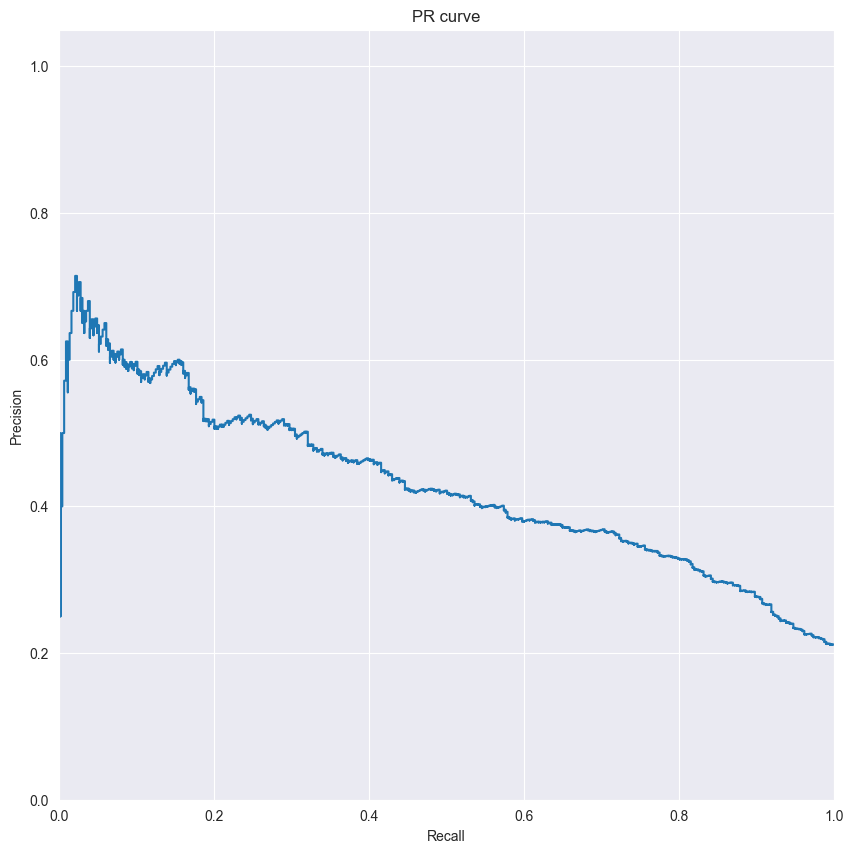

AUC: 0.7387909233050155


In [42]:
model = LogisticRegression(random_state=42, solver='liblinear', C = 1.0, max_iter = 100)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show() 

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Threshold = 0.00 | Precision = 0.211, Recall = 1.000 | F1-score = 0.349
Threshold = 0.05 | Precision = 0.233, Recall = 0.955 | F1-score = 0.374
Threshold = 0.10 | Precision = 0.285, Recall = 0.882 | F1-score = 0.431
Threshold = 0.15 | Precision = 0.332, Recall = 0.785 | F1-score = 0.467
Threshold = 0.20 | Precision = 0.371, Recall = 0.657 | F1-score = 0.474
Threshold = 0.25 | Precision = 0.400, Recall = 0.563 | F1-score = 0.468
Threshold = 0.30 | Precision = 0.419, Recall = 0.459 | F1-score = 0.438
Threshold = 0.35 | Precision = 0.460, Recall = 0.385 | F1-score = 0.420
Threshold = 0.40 | Precision = 0.487, Recall = 0.322 | F1-score = 0.387
Threshold = 0.45 | Precision = 0.515, Recall = 0.251 | F1-score = 0.337
Threshold = 0.50 | Precision = 0.516, Recall = 0.187 | F1-score = 0.274
Threshold = 0.55 | Precision = 0.586, Recall = 0.161 | F1-score = 0.252
Threshold = 0.60 | Precision = 0.592, Recall = 0.099 | F1-score = 0.170
Threshold = 0.65 | Precision = 0.596, Recall = 0.073 | F1-score 

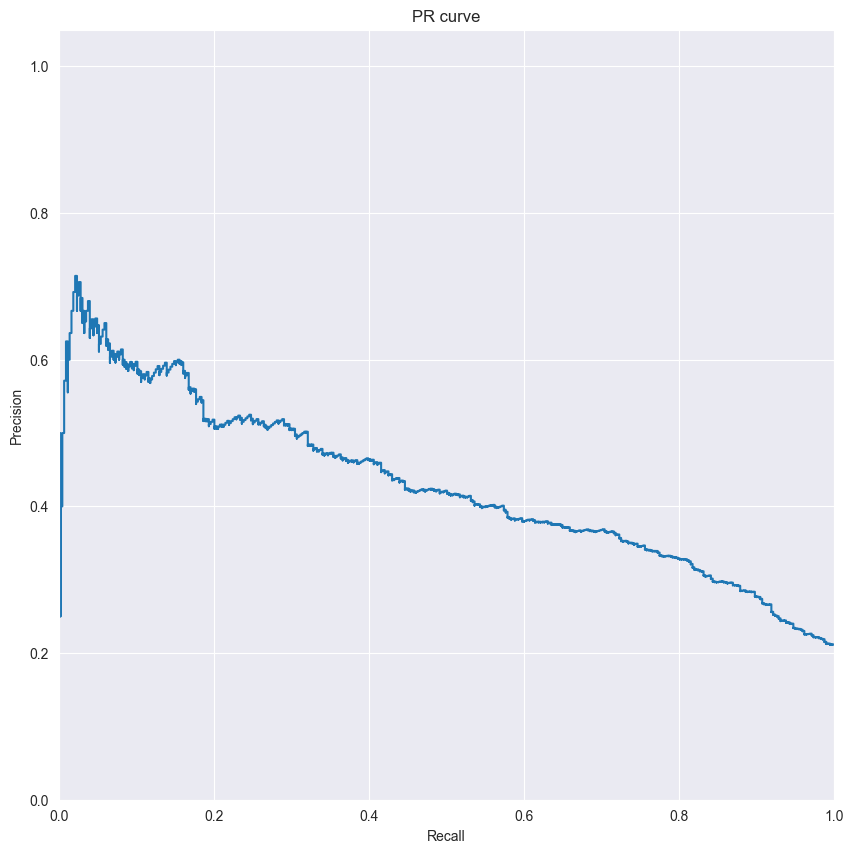

AUC: 0.7387909233050155


In [43]:
RandomForestClassifier(random_state=42, criterion= 'entropy', min_samples_split = 12, n_estimators = 10)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.95, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f} | F1-score = {:.3f}".format(
        threshold, precision, recall, f1))

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve')
plt.show()  

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Здесь тоже не наблюдается f1, нужный нам. Вывод: В данном случае самым успешным методом улучшения модели является Upsampling.

In [44]:
model = CatBoostClassifier(verbose=100, random_state=42)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score (target_valid, probabilities_one_valid)

print("AUC:", auc_roc)

Learning rate set to 0.02844
0:	learn: 0.6775865	total: 19ms	remaining: 19s
100:	learn: 0.4221508	total: 1.43s	remaining: 12.7s
200:	learn: 0.3839778	total: 2.45s	remaining: 9.74s
300:	learn: 0.3570495	total: 3.46s	remaining: 8.04s
400:	learn: 0.3319150	total: 4.47s	remaining: 6.67s
500:	learn: 0.3102748	total: 5.47s	remaining: 5.45s
600:	learn: 0.2911898	total: 6.48s	remaining: 4.3s
700:	learn: 0.2734897	total: 7.46s	remaining: 3.18s
800:	learn: 0.2574719	total: 8.41s	remaining: 2.09s
900:	learn: 0.2429422	total: 9.14s	remaining: 1s
999:	learn: 0.2292046	total: 9.79s	remaining: 0us
F1: 0.6070686070686071
AUC: 0.8544517749984633


## Тестирование модели:

In [45]:
#Проверим на тестовой выборке нашу модель: 
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.598984771573604


F1 > 0.59, тестирование модели прошло успешно, модель обучилась!

In [46]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score (target_test, probabilities_one_test)

print("AUC:", auc_roc)

AUC: 0.8497858685329576


AUC-ROC выше чем F1, и выше случайной модели (>0.5), это хороший результат. Значит, модель обучена успешно.

<b>Вывод: </b> 

Я подготовила данные: загрузила необходимые библиотеки, в процессе изучения данных обнаружила, что колонки названы неудобно для работы, привела их к нижнему и земному регистру. Рассмотрев отдельно целевой признак, обнаружила дисбаланс классов. Удалила не влияющие на обучение колонки, чтобы не загружать объемом данные, и не замедлять работу. Обнаружив значения nan, заменила их на -1. 

Я провела исследование задачи: поделила данные на 3 части (тренировочную, тестовую, валидационную выборки), преобразовала категориальные признаки в численные, провела масштабирование. И попробовала обучить модели до балансировки классов + подберем оптимальные гиперпараметры. Самый хороший результат показал catboost, но f1 нас так и не устроил. Посмотрим, что будем после балансировки классов. 

Использовала 3 метода для борьбы с дисбалансом: usampling, downsampling, change threshold. В результате лучшим оказался upsampling на алгоритме catboost. Проверим модель на тестовых данных. Да, F1 выше 0.59, AUC-ROC = 0.85. Задача выполнена, модель обучена успешно.